In [7]:
import wordcloud
import boto3
import re
import pprint
from nltk.tokenize import sent_tokenize
%reload_ext autoreload

In [18]:
import json
import os

config_file_path = os.environ['VIRTUAL_ENV']+'/config.json'

with open(config_file_path) as f:
    config = json.load(f)
    # authentication 
    AWS_ACCESS_KEY = config['access_key']
    AWS_SECRET_ACCESS_KEY = config['secret_key']
    AWS_REGION = boto3.Session().region_name

    input_file_path = config['input_path']
    output_file_path = config['output_path']


In [19]:
# configuration AWS
client_comprehend = boto3.client(
    'comprehend',
    region_name=AWS_REGION,
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

In [20]:
def getSentiment(text, isCombined):
    ## find topics 
    keys = set()
    avgSentiment = 0.0
    
    response_key_phrases = client_comprehend.detect_key_phrases(
        Text=text,
        LanguageCode='en'
    )
    ## get the key phrases
    key_phrases = list(set([x['Text'] for x in response_key_phrases['KeyPhrases'] if float(x['Score'])*100 > 98.0]))


    response_sentiment = client_comprehend.detect_sentiment(
        Text=text,
        LanguageCode='en'
    )
    
#     sentiment = response_sentiment['Sentiment']
    sentimentScore = response_sentiment['SentimentScore']['Negative']
#         keys = keys.union(set(key_phrases))    
    return key_phrases, sentimentScore

In [21]:
def analyseSentence(text):
    topics = []
    avgSentiment = 0.0
    # split input string with [, .] delimeters
    splitedSentence = re.split('; |, |\.|\*|\n', text)
    return getSentiment(text, True)

In [22]:
# project data source file
from dataSource import getData
import pandas as pd

comment_list = getData(input_file_path)
topicColumn = []
sentimentColumn = []
topicCollection = []

for comment in comment_list:
    topics, sentiment = analyseSentence(comment)
    topicCollection = topicCollection + topics
    
    topicsAsSentence = ','.join([each for each in topics])
    topicColumn.append(topicsAsSentence)
    sentimentColumn.append(sentiment)

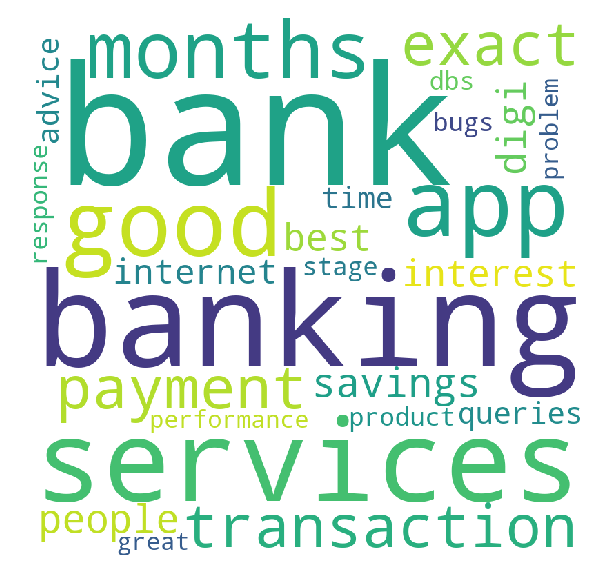

In [23]:
from wordCloud import showWordCloud
showWordCloud(topicCollection)
    

In [ ]:
import numpy as np

dataToStore = {
    'topic': topicColumn,
    'Negative': sentimentColumn
}
# print(topicCollection)
df = pd.DataFrame(dataToStore)
df.to_csv(output_file_path, sep='\t', encoding='utf-8')

In [ ]:
# text input
# text = "Team, each time I use the app for making payment, it gets hanged up at each stage and now I am unable to logout. Even though your banking services are very good, the app is not consistent enough to handle the transaction despite of good internet but whereas other bank apps do work better in a lower internet speed too. Please review the bugs and get the same fixed at the earliest possible"
# topicsList, sentiment = analyseSentence(text)
# print(sentiment)